## 0 - Import libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

# Set up the paths
cleaned_data_path = os.path.join('..', 'data', 'cleaned')
processed_data_path = os.path.join('..', 'data', 'processed')

report_path = os.path.join('..', 'reports')
figure_path = os.path.join('..', 'reports', 'figures')
model_path = os.path.join('..', 'models')


In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)

## 1 - Load and prepare the training dataset

In [3]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
#importlib.reload(build_features)

import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [4]:
# Load the variables dictionary and return the features list
varaibles_path = os.path.join(cleaned_data_path, 'variables.json')
features = build_features.load_features(varaibles_path)

# Load and clean the REASON FOR VISIT classification summary of codes
rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
rfv_df = build_features.load_rfv(rfv_path)

# Load the list of three-digit categories of ICD-9-CM
icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
icd9cm_df = build_features.load_icd9cm(icd9cm_path)

icd9cm_category = 'CATEGORY_1'

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 36


In [5]:
# Define the function to load and prepare the data
def prepare_data(df, df_type, features, rfv_df, icd9cm_df, icd9cm_category, figure_path):
    df = build_features.build_features(df, rfv_df, icd9cm_df, category=icd9cm_category)

    # Drop the rows from with NA in 'DIAG1_CAT'
    non_missing_mask = df['DIAG1_CAT'].notna()
    procd_df = df.loc[
        non_missing_mask,
        ['DIAG1_CAT'] + features + [
            'RFV1_MOD1', 'RFV1_MOD2', 'RFV2_MOD1', 'RFV2_MOD2', 'RFV3_MOD1', 'RFV3_MOD2',
            'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
        ]
    ].copy()
    print(f'Number of available dependent samples: {non_missing_mask.sum()}')
    print()

    # Combine and preprocess textual features
    procd_df['TEXT'] = procd_df.apply(lambda x: build_features.combine_textual(x, features), axis=1)

    # Add in sentence embeddings using BERT and pre-trained BiomedBERT model
    #procd_df = build_features.generate_embeddings(procd_df)

    # Add in topic feature (topic probabilities) using LDA
    procd_df, vectorizer, tf, lda, topic_features = build_features.generate_topic_features(
        procd_df, n_topics=10, n_top_words=10, transform='log'
    )

    # Visualize the topics with pyLDAvis
    lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
    pyLDAvis.save_html(lda_vis, os.path.join(figure_path, f'{df_type}_lda_vis.html'))

    # Plot the heat map of topic distributions among the labels in the dataset with Altair
    topic_df = procd_df[['DIAG1_CAT'] + topic_features].melt(id_vars='DIAG1_CAT', var_name='Topic', value_name='Probability')

    chart(
        df=topic_df,
        y='DIAG1_CAT:N',
        x='Topic:N',
        color='Probability:Q',
        title=f'Distribution of the Labels in the {df_type} Dataset',
    ).mark_rect().configure_axisY(
        labelLimit=500, title=None
    ).configure_axisX(
        labelAngle=45,
        title=None
    ).properties(width=300, height=500).save(os.path.join(figure_path, f'{df_type}_topic_distribution_heatmap.png'), ppi=300)

    # Plot the distribution and percentage of true labels
    chart(
        df=procd_df['DIAG1_CAT'].value_counts(normalize=True).reset_index(),
        x='DIAG1_CAT:N',
        y='proportion:Q',
        title=f'Distribution of the Labels in the {df_type} Dataset',
    ).mark_bar().configure_axisX(labelAngle=45, labelLimit=300, title=None).configure_axisY(title=None).save(os.path.join(figure_path, f'{df_type}_label_distribution.png'), ppi=300)
    
    return procd_df

### 1.1 - Load the training dataset

In [6]:
procd_train_path = os.path.join(processed_data_path, 'procd_train.parquet')

if os.path.exists(procd_train_path):
    procd_train = pd.read_parquet(procd_train_path)
else:
    # Load the training dataset
    train_df = pd.read_parquet(os.path.join(cleaned_data_path, 'train.parquet'))

    procd_train = prepare_data(train_df, 'train', features, rfv_df, icd9cm_df, icd9cm_category, figure_path)
    procd_train.to_parquet(procd_train_path)

Number of available dependent samples: 78946

Topic 0:
mental disorders psychological symptom depression referable chronic routine nervousness anxiety

Topic 1:
symptom musculoskeletal ache soreness pain system discomfort referable hypertension diabetes

Topic 2:
counseling medical symptom disorders adverse_effect mental psychological treatment drug chronic

Topic 3:
symptom nervous system sense exclude organs referable symptoms pain digestive

Topic 4:
symptom respiratory referable system new child_or_teenager symptoms fever cough normal_temperature

Topic 5:
postoperative specific treatment surgery preoperative pre post therapy types therapeutic

Topic 6:
skin disease test hair results nails symptom hypertension diseases genitourinary

Topic 7:
preventive screening diagnostic general prenatal baby insurance exam examinations routine

Topic 8:
injury adverse injuries type location and or effect poison unintentional

Topic 9:
progress visit nec nos treatment chronic routine hypertensio

In [7]:
# Define the X_train and y_train
X_train = procd_train.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_train = procd_train['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (78946, 58)
y Shape: (78946,)


In [8]:
# Load and display the pyLDAvis from saved html file
from IPython.display import IFrame
IFrame(src=os.path.join(figure_path, 'train_lda_vis_.html'), width=800, height=600)

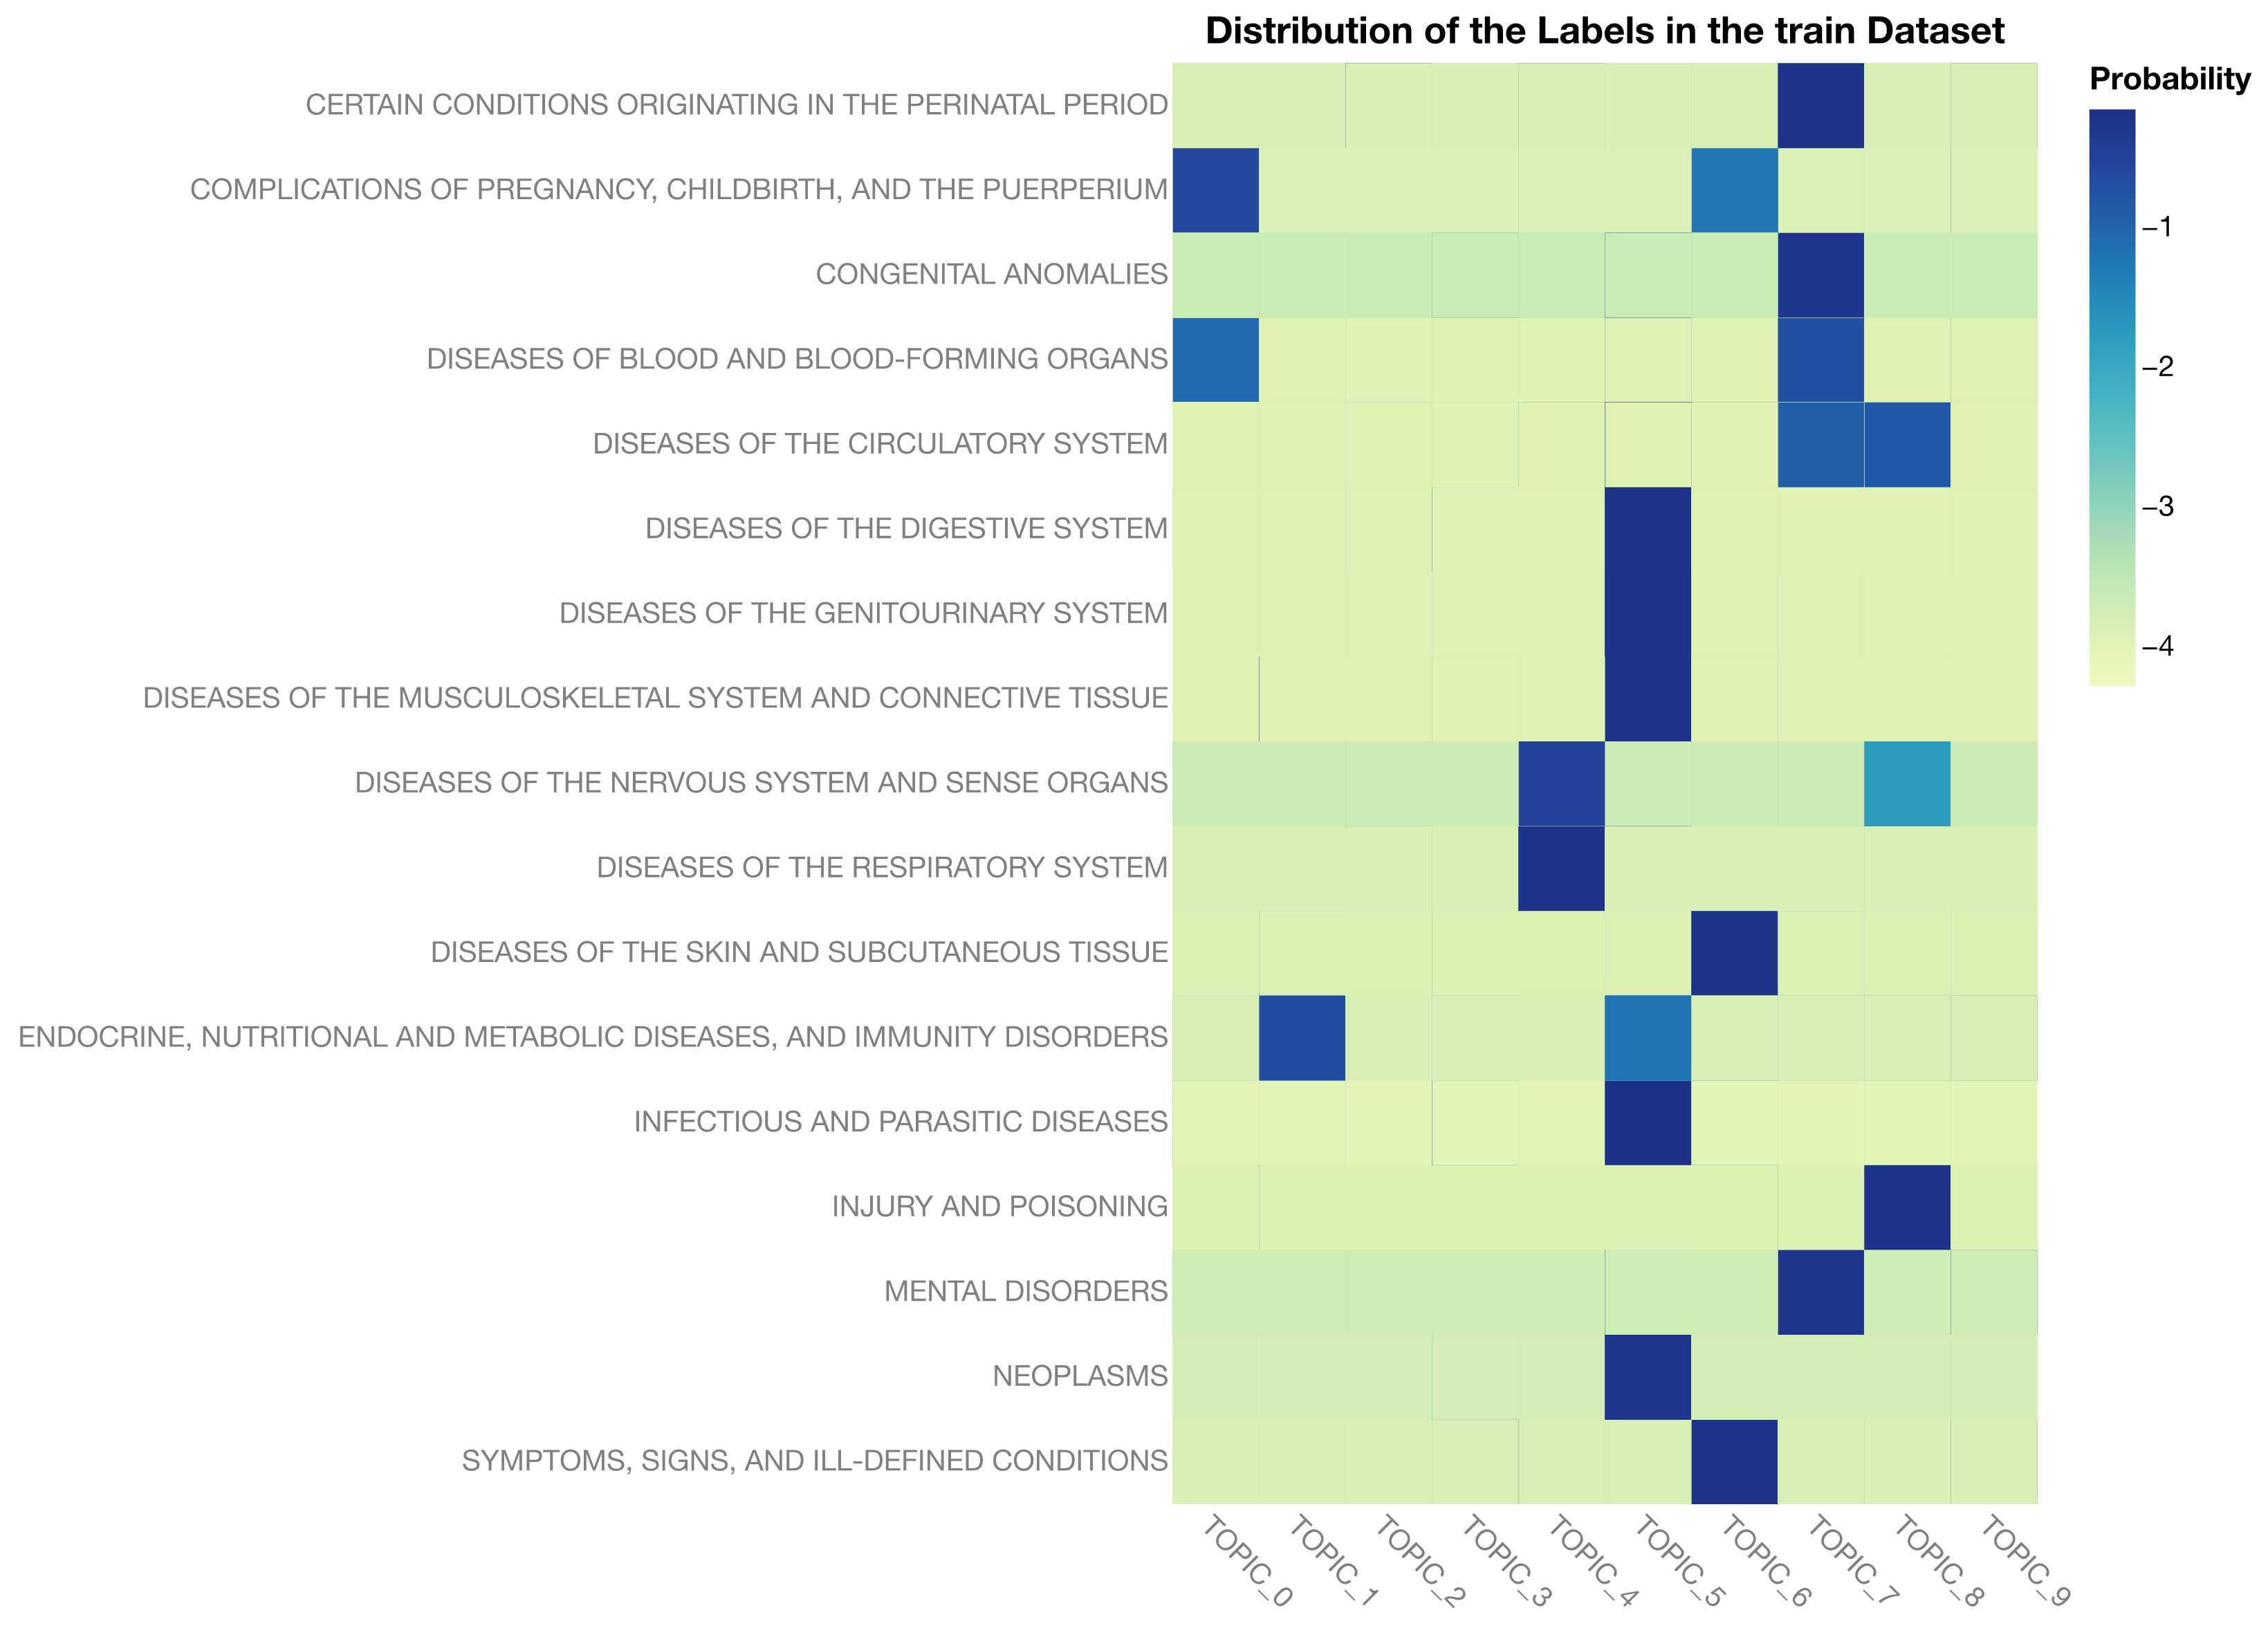

In [9]:
# Load and display the heat map of topic distributions among the labels
from IPython.display import Image
Image(filename=os.path.join(figure_path, 'train_topic_distribution_heatmap.png'))

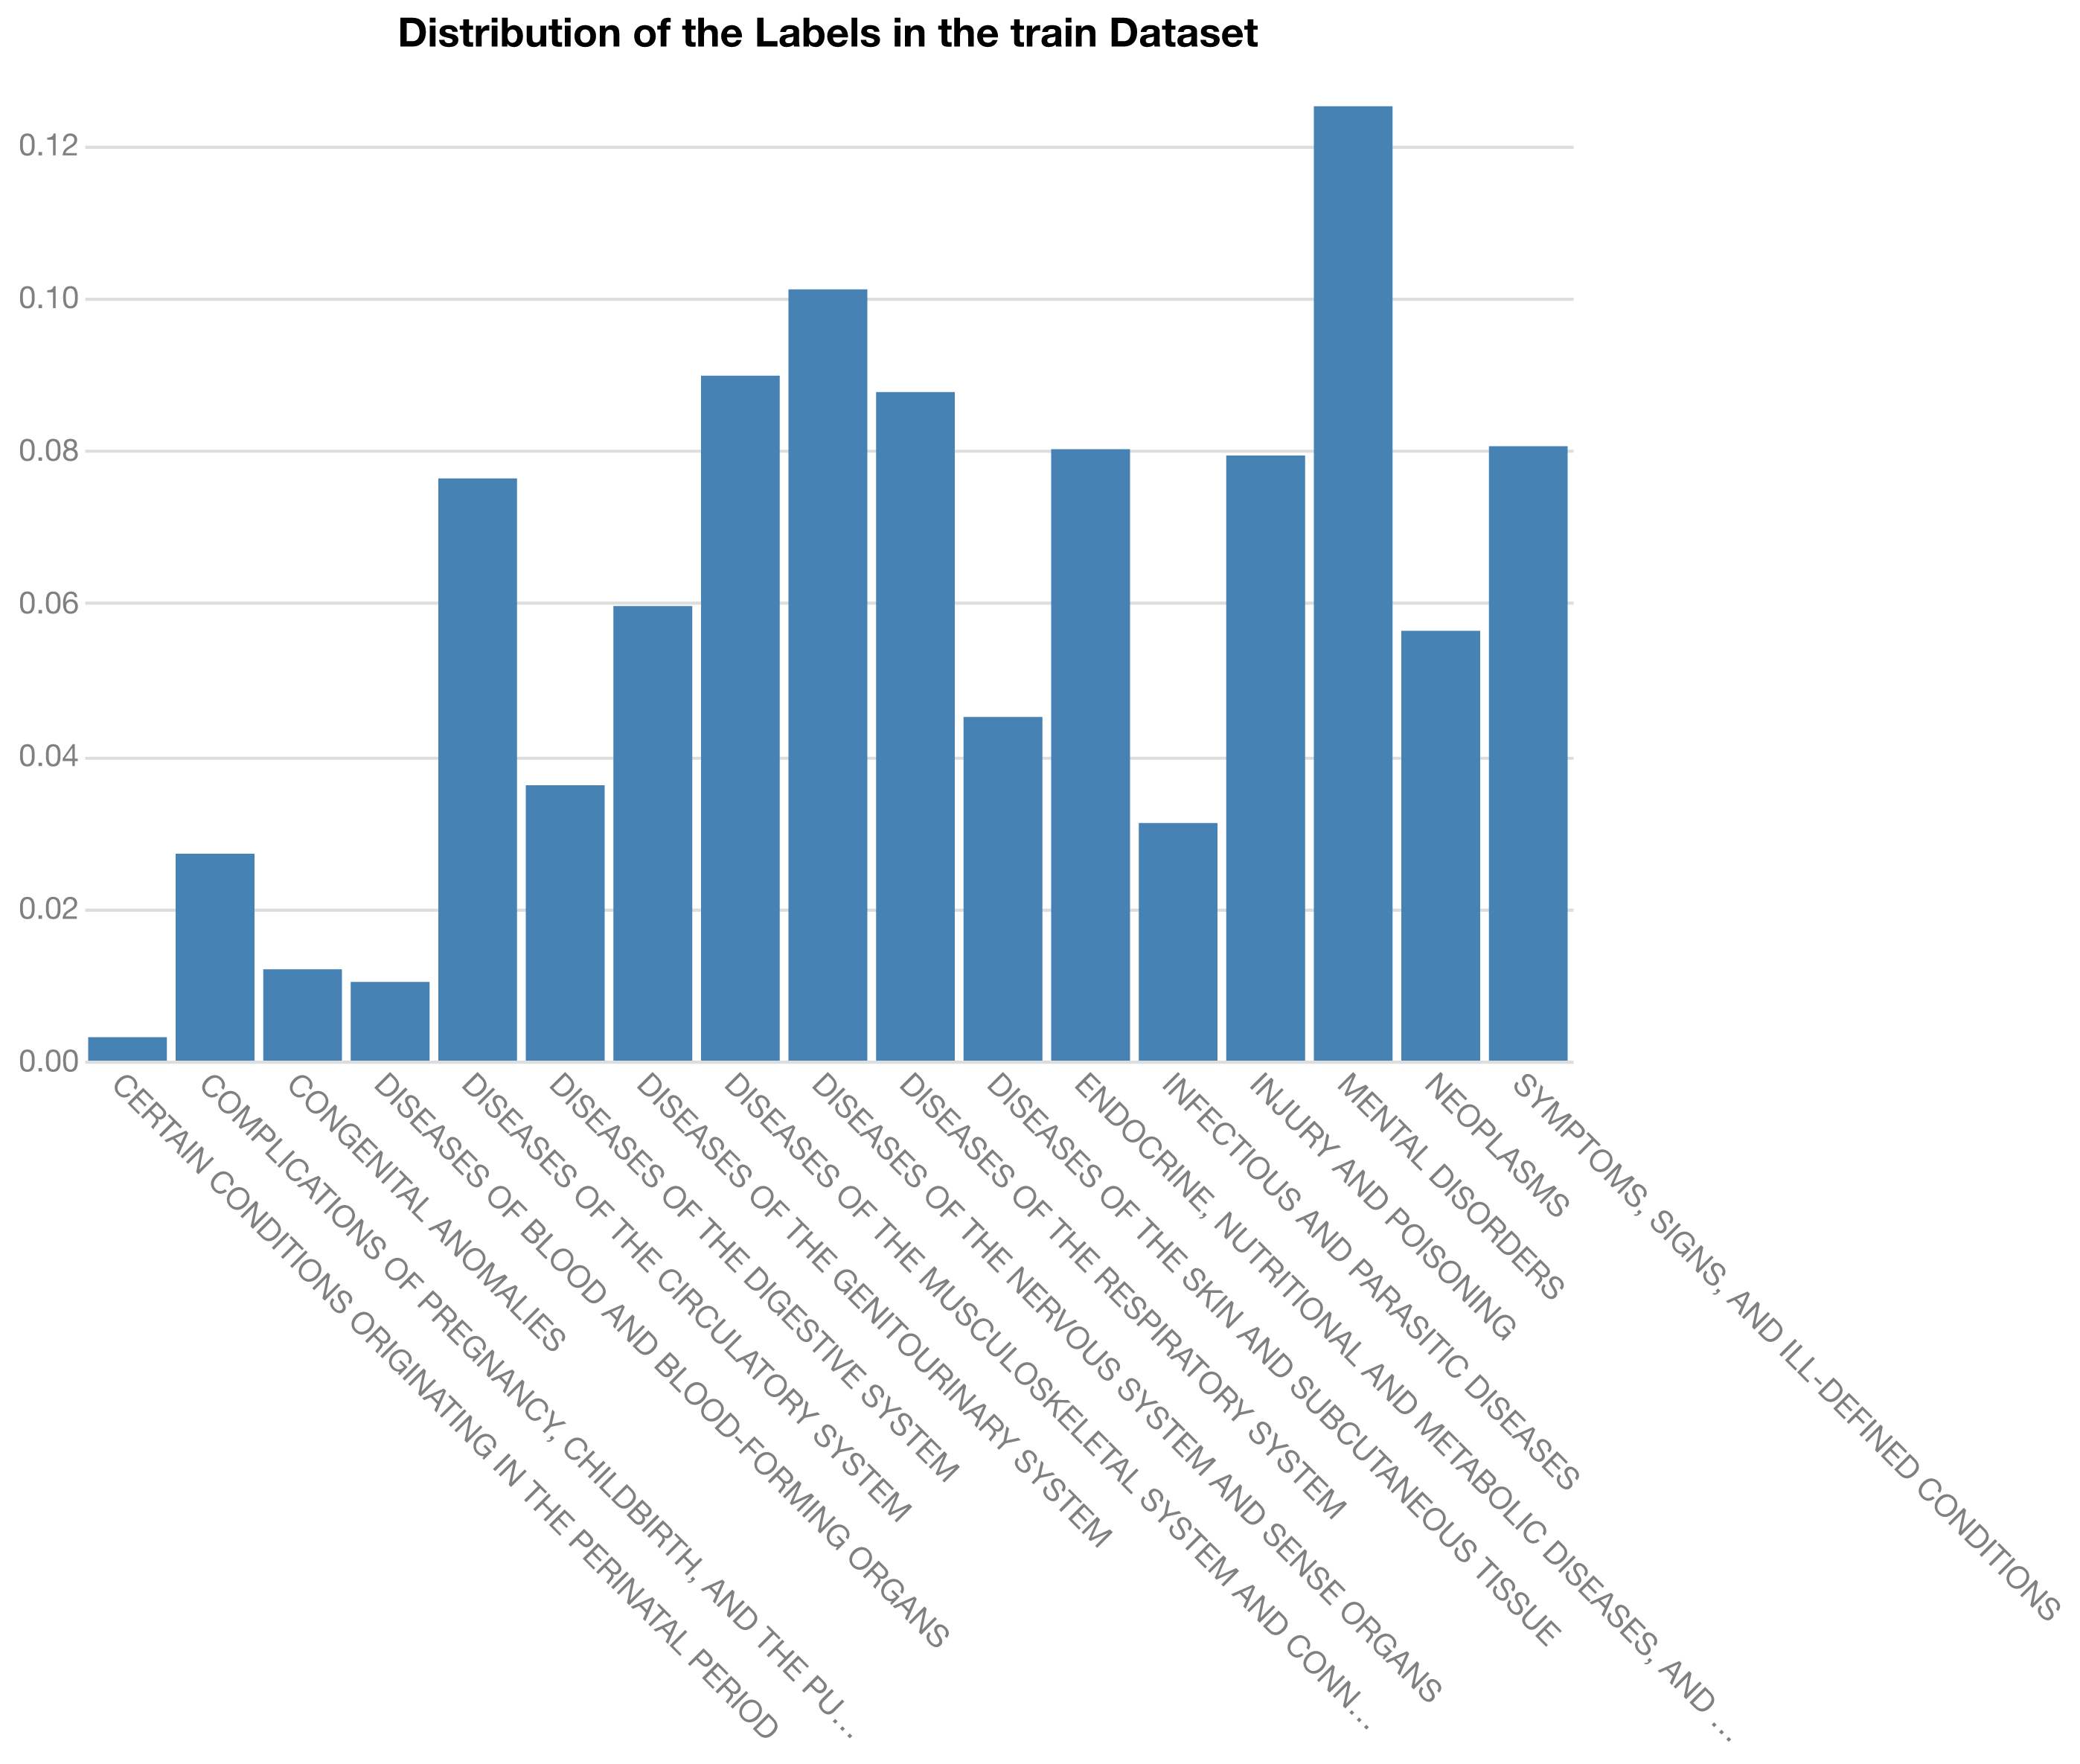

In [10]:
# Load and display the distribution and percentage of the labels
from IPython.display import display
display(Image(filename=os.path.join(figure_path, 'train_label_distribution.png')))

## 2 - Load and prepare the validation dataset

### 2.1 - Load the validation dataset

In [11]:
procd_val_path = os.path.join(processed_data_path, 'procd_val.parquet')

if os.path.exists(procd_val_path):
    procd_val = pd.read_parquet(procd_val_path)
else:
    # Load the validation dataset
    val_df = pd.read_parquet(os.path.join(cleaned_data_path, 'val.parquet'))

    procd_val = prepare_data(val_df, 'val', features, rfv_df, icd9cm_df, icd9cm_category, figure_path)
    procd_val.to_parquet(procd_val_path)

Number of available dependent samples: 25805

Topic 0:
disease postoperative diseases preoperative hypertension cancer endocrine nutritional pre post

Topic 1:
progress visit nec nos treatment routine chronic female hypertension normal_diastolic_blood_pressure

Topic 2:
counseling medical treatment therapy types specific chronic depression nos routine

Topic 3:
test results adverse_effect result surgical medicinal drug medical care blood

Topic 4:
skin hair nails symptom therapeutic specific referable lesion procedures tissue

Topic 5:
preventive screening diagnostic general prenatal baby insurance exam examinations examination

Topic 6:
symptom referable disorders mental psychological nervous sense exclude ears eyes

Topic 7:
symptom system respiratory referable symptoms new digestive cough fever child_or_teenager

Topic 8:
injury symptom musculoskeletal ache soreness pain discomfort unspecified system injuries

Topic 9:
symptom genitourinary system disease referable general female sy

In [12]:
# Define the X_val and y_val
X_val = procd_val.drop(columns='DIAG1_CAT').copy()
print(f'X Shape: {X_train.shape}')

y_val = procd_val['DIAG1_CAT'].copy()
print(f'y Shape: {y_train.shape}')

X Shape: (78946, 58)
y Shape: (78946,)


## 3 - Grid Search

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

random_state = 42

### 3.0 - Define the features, the pipeline for training, and the grid search function

In [14]:
# Set up the features

binary_features = [
    'SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS'
]
print(f'Binary Features: {binary_features}')
print()

# With Binned Groups
quantitative_features_w_bin = ['PASTVIS', 'HTIN', 'WTLB']
print(f'Quantitative Features with Binned Groups: {quantitative_features_w_bin}')

nominal_features_w_bin = ['INJDET', 'MAJOR'] + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2'] + ['AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
print(f'Nominal Features with Binned Groups: {nominal_features_w_bin}')

print(f'Number of Features with Binned Groups: {len(quantitative_features_w_bin + binary_features + nominal_features_w_bin)}')
print()

# Without Binned Groups
quantitative_features_wo_bin = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
print(f'Quantitative Features without Binned Groups: {quantitative_features_wo_bin}')
nominal_features_wo_bin = ['INJDET', 'MAJOR'] + ['RFV1', 'RFV2', 'RFV3']
print(f'Nominal Features without Binned Groups: {nominal_features_wo_bin}')

print(f'Number of Features without Binned Groups: {len(quantitative_features_wo_bin + binary_features + nominal_features_wo_bin)}')


Binary Features: ['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']

Quantitative Features with Binned Groups: ['PASTVIS', 'HTIN', 'WTLB']
Nominal Features with Binned Groups: ['INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
Number of Features with Binned Groups: 32

Quantitative Features without Binned Groups: ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
Nominal Features without Binned Groups: ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
Number of Features without Binned Groups: 29


In [15]:
# Set up the pipeline

def set_pipeline(model, binary_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5, pca=None, ovr=False):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
        ],
        remainder='passthrough',
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    if ovr:
        model = OneVsRestClassifier(model)
    
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', model),
    ]
    
    if pca is not None:
        steps.insert(-1, ('pca', PCA(n_components=pca)))

    pipeline = Pipeline(steps)

    return pipeline

In [16]:
# Set up the grid search function

def grid_search(pipeline_func, model, binary_features, nominal_features, quantitative_features, imputer, X_train, y_train, param_grid, X_val, y_val):
    """Looping over the parameter grid to find the best model."""
    best_pipeline = None
    best_params = {}
    best_score = -np.inf

    for params in ParameterGrid(param_grid):
        print(f'Fitting model with parameters: {params}')

        if params.get('pca__n_components') is None:
            pipeline = pipeline_func(
                model, binary_features, nominal_features, quantitative_features, imputer
            )
            params.pop('pca__n_components', None)
        else:
            pipeline = pipeline_func(
                model, binary_features, nominal_features, quantitative_features, imputer, pca=params.get('pca__n_components')
            )
        
        pipeline.set_params(**params).fit(X_train, y_train)

        print(f'Predicting model with parameters: {params}')
        y_pred = pipeline.predict(X_val)

        
        score = f1_score(y_val, y_pred, average='weighted')

        if score > best_score:
            best_score = score
            best_params = params
            best_pipeline = clone(pipeline)

    return best_pipeline, best_params, best_score
        

### 3.1 - Logistic Regression

In [22]:
# Define the feature sets
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']
topic_features = [col for col in X_train.columns if col.startswith('TOPIC')]

clf_features = binary_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')

Missing Values in X_train: 
PASTVIS       15702.0
HTIN          44208.0
WTLB          27592.0
BMI           48130.0
TEMPF         41616.0
BPSYS         31244.0
BPDIAS        31342.0
RFV1_TEXT       971.0
RFV2_TEXT     48999.0
RFV3_TEXT     67936.0
DIAG2_TEXT    36722.0
DIAG3_TEXT    58663.0
dtype: float64

Shape of X_train: (78946, 36)
Features to be fit: 
Index(['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2',
       'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
       'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN',
       'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS',
       'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT',
       'DIAG3_TEXT'],
      dtype='object')


In [ ]:
# Define the parameter grid
param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'pca__n_components': [None, 0.95, 5, 10],
    'preprocessor__impute__n_neighbors': [5, 10, 15],
}

In [ ]:
model=LogisticRegression(
    random_state=random_state, n_jobs=-1,
    max_iter=1000, class_weight='balanced'
)

best_pipeline_lr, best_params_lr, best_score_lr = grid_search(
    set_pipeline,
    model,
    binary_features,
    nominal_features,
    quantitative_features,
    imputer='knn',
    X_train=X_train[clf_features],
    y_train=y_train,
    param_grid=param_grid_lr,
    X_val=X_val[clf_features],
    y_val=y_val
)